In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
df1 = pd.read_csv('dataset_1_colon_cancer.csv')
df2 = pd.read_csv('dataset_2_colon_cancer.csv')


print("Initial shapes:")
print("Dataset 1:", df1.shape)
print("Dataset 2:", df2.shape)



Initial shapes:
Dataset 1: (300, 6)
Dataset 2: (100, 6)


In [2]:
df1

,AGE,CEA Level,Colonoscopy Result,Polyp Size (mm),Family History,Type of Colon Cancer
0,78,17.361410,Normal,14.969663,No,1
1,68,14.008226,Normal,9.495306,Yes,1
2,54,12.445401,Normal,44.941506,Yes,3
3,82,4.139308,Abnormal,4.931454,No,1
4,47,8.935027,Normal,26.701058,No,2
...,...,...,...,...,...,...
295,72,3.291327,Abnormal,15.145993,Yes,1
296,53,2.961422,Abnormal,18.427963,Yes,1
297,60,9.088109,Abnormal,36.233249,No,1
298,59,16.684683,Normal,15.558964,Yes,3


In [3]:
df2

,Tumor Grade,Biopsy Result,Lymph Node Involvement,Bowel Obstruction,Smoking History,Type of Colon Cancer
0,3,Positive,Yes,Yes,Non-Smoker,3
1,3,Negative,Yes,Yes,Smoker,2
2,2,Negative,No,No,Non-Smoker,3
3,1,Negative,Yes,No,Smoker,2
4,1,Negative,No,No,Non-Smoker,2
...,...,...,...,...,...,...
95,3,Negative,Yes,Yes,Smoker,2
96,3,Positive,Yes,Yes,Smoker,3
97,3,Negative,Yes,Yes,Smoker,2
98,3,Negative,Yes,Yes,Smoker,3


DATA PREPROCESSING

In [4]:
# Initialize LabelEncoder for categorical variables processing
le = LabelEncoder()

def process_dataset_one(df):
    """
    Preprocess Dataset 1: Contains patient clinical measurements and history.
    Key steps: Copy dataframe, encode categorical vars, add placeholders for Dataset 2 features
    """
    processed_df = df.copy()
    
    # Convert categorical features to numerical using label encoding
    categorical_features = ['Colonoscopy Result', 'Family History']
    for feature in categorical_features:
        processed_df[feature] = le.fit_transform(processed_df[feature])
    
    # Initialize Dataset 2 features with NaN - Required for later merging
    dataset2_features = {
        'Tumor Grade': np.nan,
        'Biopsy Result': np.nan,
        'Lymph Node Involvement': np.nan,
        'Bowel Obstruction': np.nan,
        'Smoking History': np.nan
    }
    for feature, value in dataset2_features.items():
        processed_df[feature] = value
        
    return processed_df

def process_dataset_two(df):
    """
    Preprocess Dataset 2: Contains pathology and additional risk factors.
    Key steps: Copy dataframe, encode categorical vars, add placeholders for Dataset 1 features
    """
    processed_df = df.copy()
    
    # Convert categorical features to numerical using label encoding
    categorical_features = ['Biopsy Result', 'Lymph Node Involvement', 
                          'Bowel Obstruction', 'Smoking History']
    for feature in categorical_features:
        processed_df[feature] = le.fit_transform(processed_df[feature])
    
    # Initialize Dataset 1 features with NaN - Required for later merging
    dataset1_features = {
        'AGE': np.nan,
        'CEA Level': np.nan,
        'Colonoscopy Result': np.nan,
        'Polyp Size (mm)': np.nan,
        'Family History': np.nan
    }
    for feature, value in dataset1_features.items():
        processed_df[feature] = value
        
    return processed_df

# Process both datasets
df1_processed = process_dataset_one(df1)
df2_processed = process_dataset_two(df2)

# Merge datasets vertically
combined_df = pd.concat([df1_processed, df2_processed], axis=0, ignore_index=True)

# Check data quality - Missing values assessment
print("\nMissing values check pre-imputation:")
print(combined_df.isnull().sum())

# Define feature types for imputation
numerical_features = ['AGE', 'CEA Level', 'Polyp Size (mm)', 'Tumor Grade']
categorical_features = ['Colonoscopy Result', 'Family History', 'Biopsy Result',
                       'Lymph Node Involvement', 'Bowel Obstruction', 'Smoking History']

# Identify unique cancer types for class-specific imputation
cancer_types = combined_df['Type of Colon Cancer'].unique()

# Perform class-specific imputation
# Filling missing values by mean in each group
# Note: Using class-specific values preserves the relationship between features and target
for cancer_type in cancer_types:
    # Create mask for current cancer type
    type_mask = combined_df['Type of Colon Cancer'] == cancer_type
    
    # Handle numerical features - Use class mean
    for feature in numerical_features:
        class_mean = combined_df.loc[type_mask, feature].mean()
        combined_df.loc[type_mask, feature] = combined_df.loc[type_mask, feature].fillna(class_mean)
    
    # Handle categorical features - Use class mode
    for feature in categorical_features:
        class_mode = combined_df.loc[type_mask, feature].mode()[0]
        combined_df.loc[type_mask, feature] = combined_df.loc[type_mask, feature].fillna(class_mode)

# Verify data quality post-imputation
print("\nMissing values check post-imputation:")
print(combined_df.isnull().sum())


Missing values check pre-imputation:
AGE                       100
CEA Level                 100
Colonoscopy Result        100
Polyp Size (mm)           100
Family History            100
Type of Colon Cancer        0
Tumor Grade               300
Biopsy Result             300
Lymph Node Involvement    300
Bowel Obstruction         300
Smoking History           300
dtype: int64

Missing values check post-imputation:
AGE                       0
CEA Level                 0
Colonoscopy Result        0
Polyp Size (mm)           0
Family History            0
Type of Colon Cancer      0
Tumor Grade               0
Biopsy Result             0
Lymph Node Involvement    0
Bowel Obstruction         0
Smoking History           0
dtype: int64


HANDLING OUTLIERS

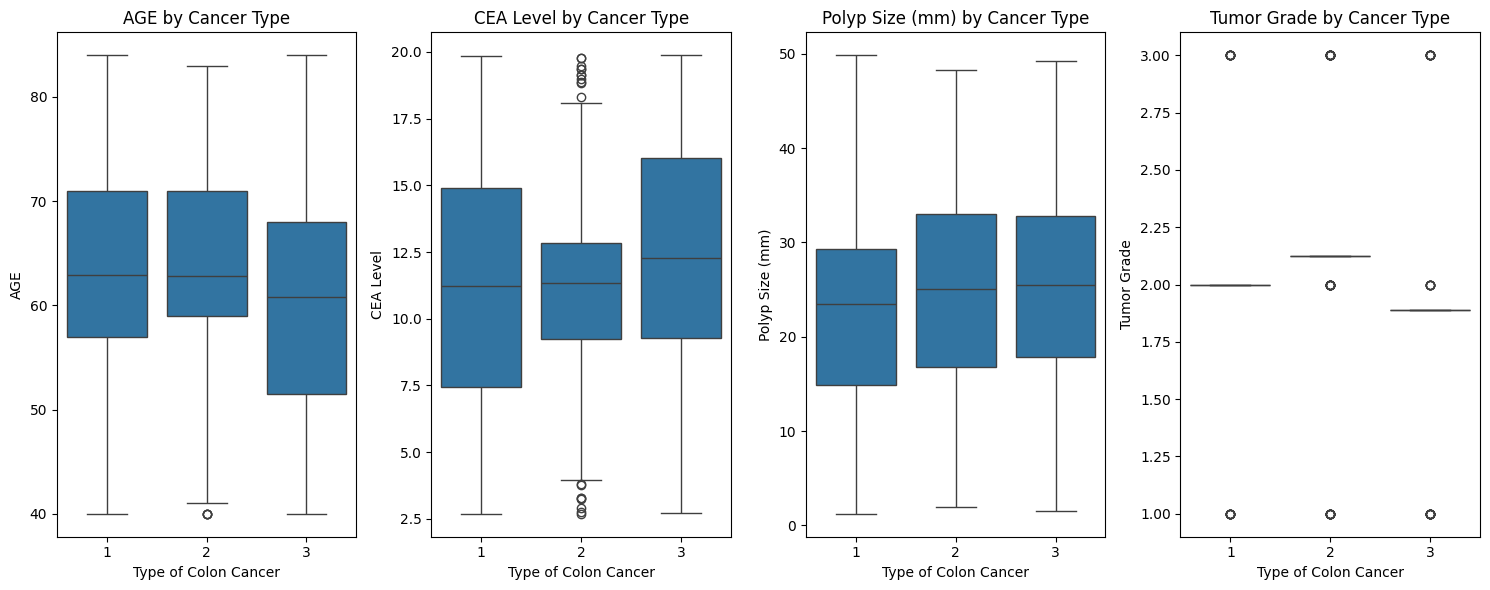

In [5]:
#From the graph we can see there are outliers existing in the dataset
plt.figure(figsize=(15, 6))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 4, i)  
    sns.boxplot(data=combined_df, y=col, x='Type of Colon Cancer')
    plt.title(f'{col} by Cancer Type')
plt.tight_layout()
plt.show()

In [6]:
# Handle outliers in numerical columns
#Using IQR method to remove outliers as it is more robust to outliers than z-score method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

combined_df = remove_outliers(combined_df, numerical_features)

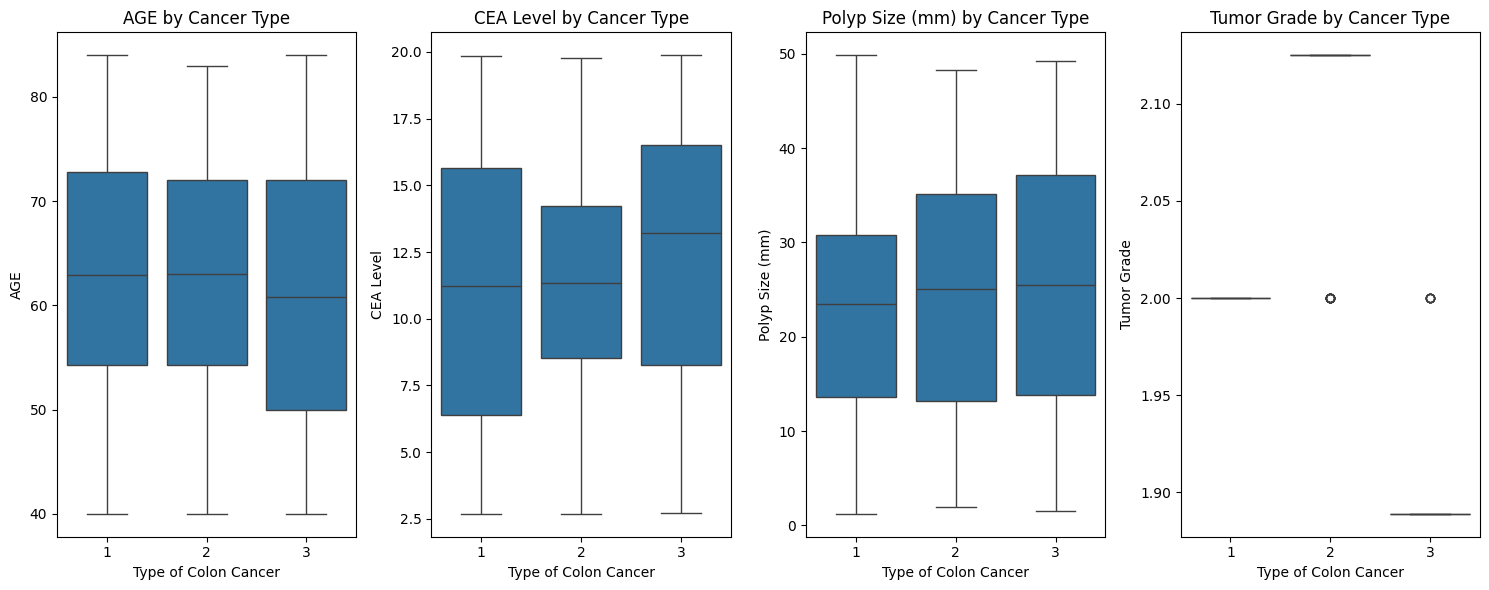

In [7]:
#Box plot after removing outliers
plt.figure(figsize=(15, 6))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, 4, i)  # 1 row, 4 columns
    sns.boxplot(data=combined_df, y=col, x='Type of Colon Cancer')
    plt.title(f'{col} by Cancer Type')
plt.tight_layout()
plt.show()

In [8]:
combined_df.describe()

,AGE,CEA Level,Colonoscopy Result,Polyp Size (mm),Family History,Type of Colon Cancer,Tumor Grade,Biopsy Result,Lymph Node Involvement,Bowel Obstruction,Smoking History
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,62.236203,11.587613,0.562874,24.644872,0.595808,1.964072,2.007360,0.347305,0.652695,0.332335,0.667665
std,12.550402,5.019889,0.496775,13.254891,0.491471,0.804583,0.091824,0.476828,0.476828,0.471757,0.471757
min,40.000000,2.689659,0.000000,1.226969,0.000000,1.000000,1.888889,0.000000,0.000000,0.000000,0.000000
25%,53.000000,7.949084,0.000000,13.517168,0.000000,1.000000,1.888889,0.000000,0.000000,0.000000,0.000000
50%,62.878788,11.335986,1.000000,24.353573,1.000000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000
75%,72.000000,15.679727,1.000000,34.851014,1.000000,3.000000,2.125000,1.000000,1.000000,1.000000,1.000000
max,84.000000,19.876884,1.000000,49.846838,1.000000,3.000000,2.125000,1.000000,1.000000,1.000000,1.000000


STANDARDIZATION

In [9]:
# Standardize numerical features
# StandardScaler is used to standardize the dataset so that the features have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
combined_df[numerical_features] = scaler.fit_transform(combined_df[numerical_features])

# Split features and target
X = combined_df.drop('Type of Colon Cancer', axis=1)
y = combined_df['Type of Colon Cancer']

# Split the data
# Spltting the data into training and testing data with 80% training data and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Verify no NaN values in training data
print("\nNaN values in training data:")
print(X_train.isnull().sum().sum())
print("NaN values in test data:")
print(X_test.isnull().sum().sum())


NaN values in training data:
0
NaN values in test data:
0


MODEL BUILDING

In [18]:
# Training Random Forest model with 100 trees
# to avoid overfitting, we can use hyperparameter tuning to find the best parameters
# Random Forest is used as it is an ensemble learning method that combines multiple decision trees to create a more accurate model

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10,max_features='sqrt',min_samples_split=10,min_samples_leaf=5)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print model performance
print("\nModel Performance:")
print(classification_report(y_test, y_pred))

# Feature Importance
# Feature importance is a measure of how much a feature contributes to the model's prediction
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()





Model Performance:


ValueError: DataFrame constructor not properly called!

MODEL OPTIMIZATION AND METRICS


Performing Cross Validation:
CV Scores: [0.95522388 0.95522388 0.95522388 0.97014925 0.96969697]
Average CV Score: 0.961 (+/- 0.014)

Train Performance:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97        91
           2       1.00      0.96      0.98        95
           3       1.00      0.98      0.99        81

    accuracy                           0.98       267
   macro avg       0.98      0.98      0.98       267
weighted avg       0.98      0.98      0.98       267


Test Performance:
              precision    recall  f1-score   support

           1       0.88      1.00      0.94        23
           2       0.95      0.91      0.93        23
           3       1.00      0.90      0.95        21

    accuracy                           0.94        67
   macro avg       0.95      0.94      0.94        67
weighted avg       0.94      0.94      0.94        67



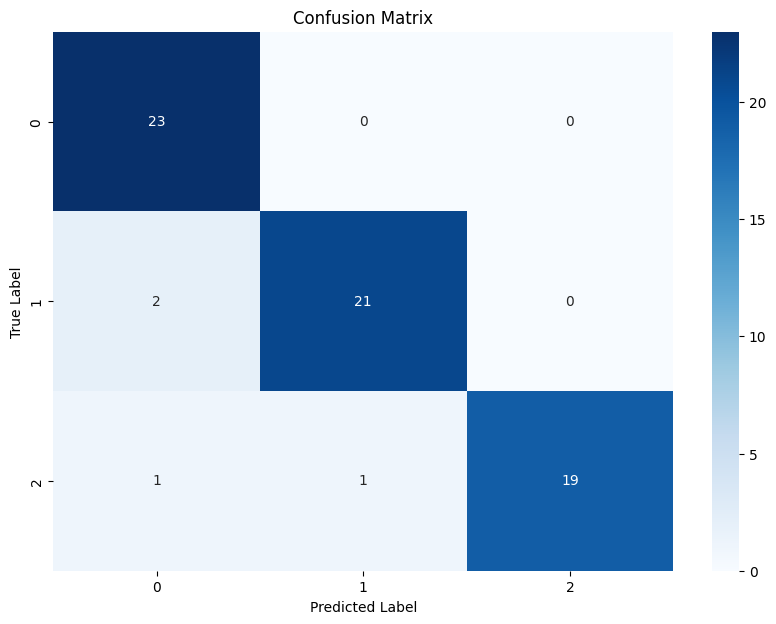


Class Distribution:
Type of Colon Cancer
2    0.353293
1    0.341317
3    0.305389
Name: proportion, dtype: float64


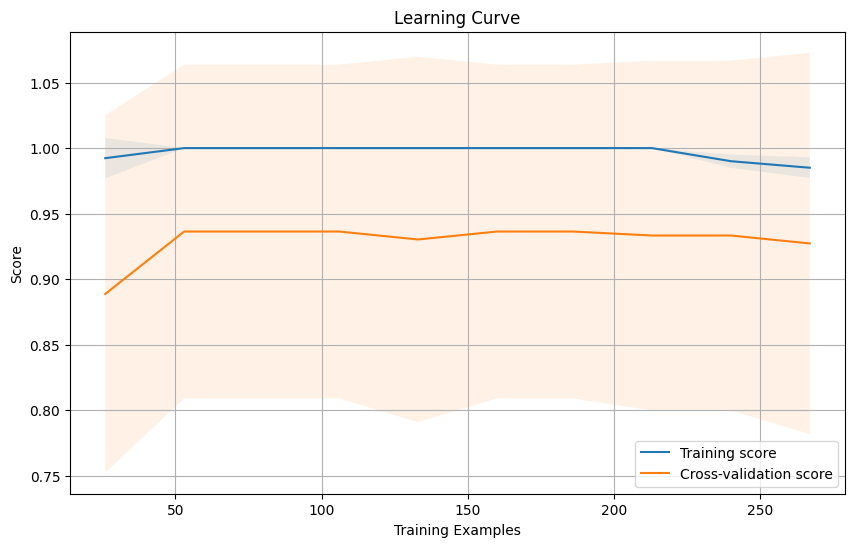

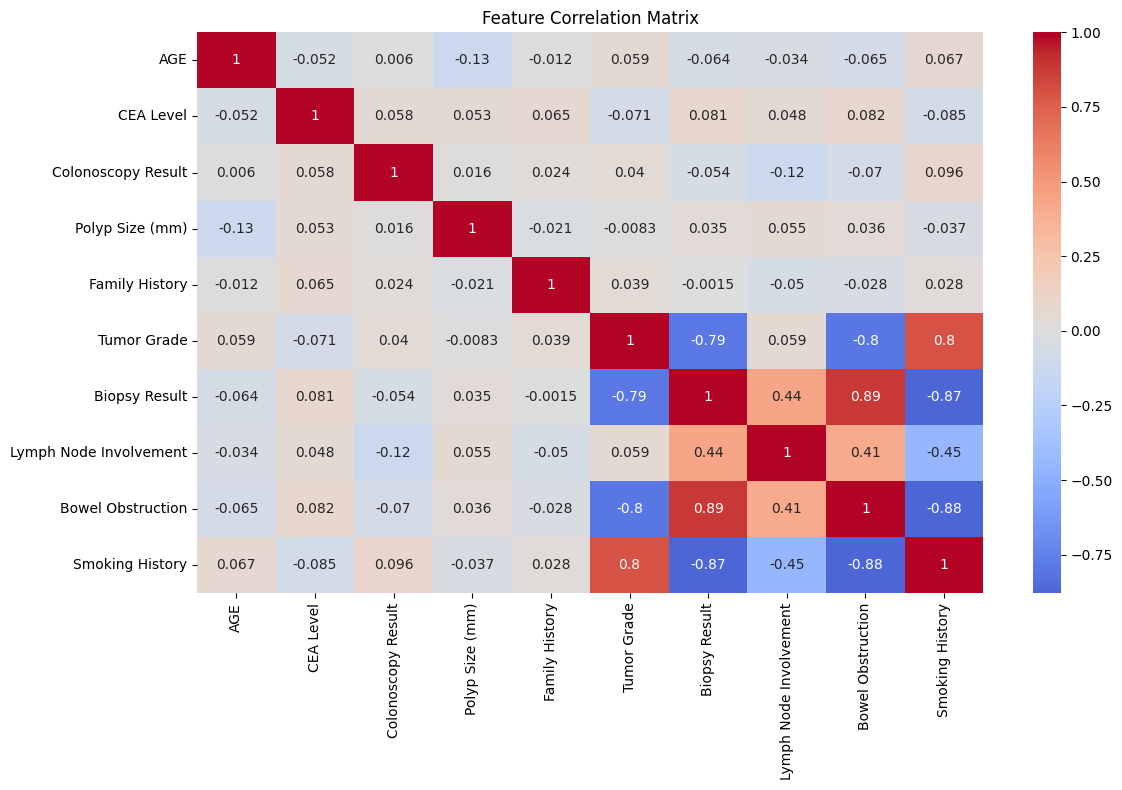

In [12]:
# Cross-validation
# Cross-validation is a technique used to evaluate the performance of a machine learning model
# It is more reliable than a single train-test split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Add cross-validation
print("\nPerforming Cross Validation:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train final model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)

# Print model performance
print("\nTrain Performance:")
print(classification_report(y_train, y_pred_train))
print("\nTest Performance:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Check for class imbalance
print("\nClass Distribution:")
print(y.value_counts(normalize=True))

# Learning curves
# Learning curves are used to evaluate the performance of a model as the training size increases
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curve(rf_model, X, y)

# Feature correlation analysis
plt.figure(figsize=(12,8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()



SHAP VALUES

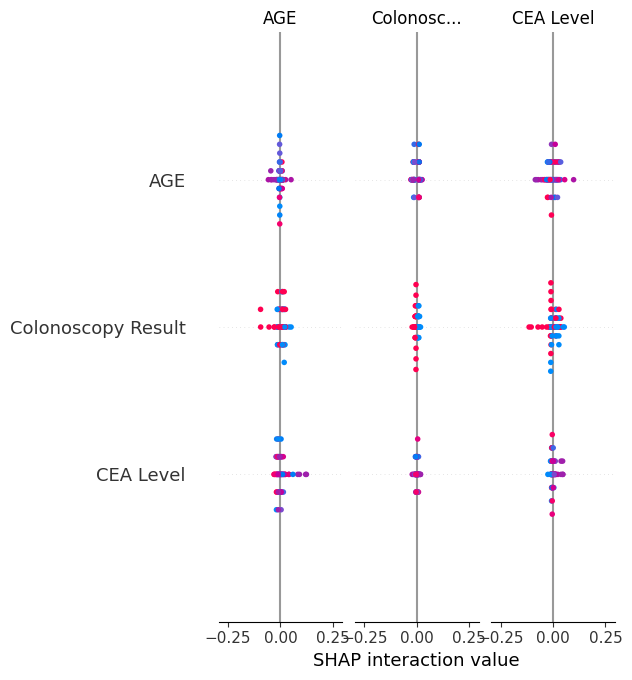

In [14]:
import shapely
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type='bar')





XGBOOST MODEL

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
# Create an instance of the XGBClassifier
xgb_clf = XGBClassifier(objective='multi:softprob',
                        random_state=42,

    # Regularization parameters
    learning_rate=0.01,        # Reduced from 0.1
    max_depth=3,              # Reduced tree depth
    min_child_weight=3,       # Increased from default 1
    gamma=0.1,               # Minimum loss reduction
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=1,            # L2 regularization
    subsample=0.8,           # Randomly sample 80% of training data
    colsample_bytree=0.8,    # Randomly sample 80% of columns
    n_estimators=200,
)

y= le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Perform K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_clf, X, y, cv=kfold)

print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

# Train the model on the full training set
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Print performance metrics
print("\nXGBoost Model Performance:")
print("Train Accuracy:", accuracy_score(y_train, xgb_clf.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Type 1', 'Type 2', 'Type 3']))

# Feature importance
feature_importance = pd.DataFrame({
   'feature': X.columns,
   'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Cross-validation scores: [0.97014925 0.97014925 1.         1.         0.98484848]
Average CV score: 0.9850293984622344
CV score std: 0.013349966029659186

XGBoost Model Performance:
Train Accuracy: 0.9925093632958801
Test Accuracy: 0.9701492537313433

Classification Report:
              precision    recall  f1-score   support

      Type 1       0.92      1.00      0.96        23
      Type 2       1.00      1.00      1.00        23
      Type 3       1.00      0.90      0.95        21

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67


Feature Importance:
                  feature  importance
5             Tumor Grade    0.283580
7  Lymph Node Involvement    0.251640
8       Bowel Obstruction    0.163665
9         Smoking History    0.121246
6           Biopsy Result    0.105240
3         Polyp Size (mm)    0.025568
0                     AGE    0.025116
1               CE